In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from itertools import chain
import cftime
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import matplotlib.patheffects as path_effects

# Famines

In [ ]:
famine_table =pd.read_excel('..data/FaminesFoodDisruptions_v2.xlsx', sheet_name='Ljungqvist2024_TableA1', header=2).iloc[:70,]

famine_table.rename(columns={"C. Europe" : "Central", "Low Countries" : "Low", "Great Britain" : "England", "Russia/Ukraine" : "Russia"}, inplace=True)
famine_table


,Italy,Spain,France,Central,Low,England,Ireland,Nordic,Russia
0,NaN,1255–62,NaN,NaN,1256–58,1258–59,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,1263,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,1270–71,NaN,NaN
3,1275–77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1281–82,NaN,NaN,NaN,NaN,"1279, 1282"
...,...,...,...,...,...,...,...,...,...
65,1764–67,1762–65,NaN,NaN,NaN,NaN,NaN,1763–65,NaN
66,NaN,NaN,NaN,1770–72,NaN,NaN,NaN,1771–73,NaN
67,NaN,1780–82,NaN,NaN,NaN,NaN,1782–84,1785,1781
68,NaN,1786–87,1788–89,1787–90,NaN,NaN,NaN,1786–87,NaN


In [3]:
famine_table = famine_table.replace({'–': '-'}, regex=True)

# Step 2: Melt the DataFrame
famine_long = famine_table.melt(var_name='Region', value_name='Period').dropna()

def parse_period(period_str):
    periods = str(period_str).split(',')
    parsed = []
    for p in periods:
        p = p.strip()
        if '-' in p:
            start_str, end_str = p.split('-')
            start = int(start_str)
            # Handle 2-digit end years
            if len(end_str) <= 2:
                century = start // 100
                end = century * 100 + int(end_str)
                if end < start:
                    end += 100
            else:
                end = int(end_str)
        else:
            start = int(p)
            end = start
        parsed.append((start, end))
    return parsed

# Step 3: Filter out overlapping sub-periods
filtered_periods_by_region = {}
for region, group in famine_long.groupby('Region'):
    all_periods = []
    for period_str in group['Period']:
        all_periods.extend(parse_period(period_str))

    # Sort periods by start year, then by end year descending (to keep longest periods first)
    all_periods.sort(key=lambda x: (x[0], -x[1]))

    non_overlapping = []
    for start, end in all_periods:
        if all(not (start >= s and end <= e) for s, e in non_overlapping):
            non_overlapping.append((start, end))
    
    filtered_periods_by_region[region] = non_overlapping

# Step 4: Build year-by-year records
famine_records = []
for region, periods in filtered_periods_by_region.items():
    for start, end in periods:
        duration = end - start + 1
        for year in range(start, end + 1):
            famine_records.append({
                'Year': year,
                'Region': region,
                'Famine_dur': duration if year == start else None,
                'Famine_dur2': duration
            })

# Step 5: Create DataFrame
famine_df = pd.DataFrame(famine_records)
famine_df = famine_df.sort_values(by=['Region', 'Year']).reset_index(drop=True)

famine_df

,Year,Region,Famine_dur,Famine_dur2
0,1281,Central,2.0,2
1,1282,Central,NaN,2
2,1315,Central,4.0,4
3,1316,Central,NaN,4
4,1317,Central,NaN,4
...,...,...,...,...
631,1782,Spain,NaN,3
632,1786,Spain,2.0,2
633,1787,Spain,NaN,2
634,1798,Spain,2.0,2


In [4]:
# Step 1: make all region × year combinations
years = np.arange(1500, 1801)  # 1500–1800 inclusive
regions = famine_df["Region"].unique()
base = pd.MultiIndex.from_product([years, regions], names=["Year", "Region"])
result = pd.DataFrame(index=base).reset_index()

# Step 2: mark famine years 
famine_years = famine_df[["Year", "Region"]].dropna().drop_duplicates()
famine_years["Famine"] = 1

# Step 3: merge and fill
result = result.merge(famine_years, on=["Year", "Region"], how="left")
result["Famine"] = result["Famine"].fillna(0).astype(int)

big_df = result

# Conflict

c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


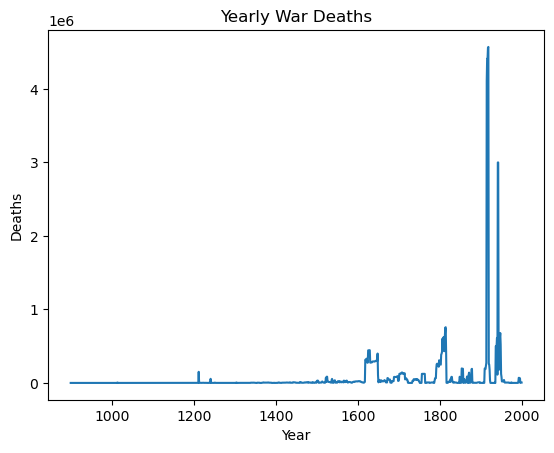

In [ ]:
# Load the data
post1400 = pd.read_excel('..data/Conflict-Catalog-18-vars.xlsx')
pre1400 = pd.read_excel('..data/Brecke-Pre-1400-European-Conflicts.xlsx')


# Convert StartYear and EndYear to integer if not NaN
post1400['StartYear'] = post1400['StartYear'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)
post1400['EndYear'] = post1400['EndYear'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)

# Filter Region to be 3 and 4
post1400 = post1400[post1400['Region'].isin([3, 4])]
# Select relevant columns
post1400 = post1400[['TotalFatalities', 'MilFatalities', 'StartYear', 'EndYear']].copy()
pre1400 = pre1400[['Fatalities', 'StartYear', 'EndYear']].copy()

# Fill NaN values in TotalFatalities and MilFatalities with 0
post1400['TotalFatalities'] = post1400['TotalFatalities'].fillna(0)
post1400['MilFatalities'] = post1400['MilFatalities'].fillna(0)
post1400['Deaths'] = post1400['TotalFatalities']

pre1400['Deaths'] = pre1400['Fatalities'].fillna(0)

# Drop TotalFatalities and MilFatalities
post1400 = post1400.drop(columns=['TotalFatalities', 'MilFatalities'])

pre1400 = pre1400.drop(columns=['Fatalities'])

wars = pd.concat([pre1400,post1400])

# Initialize an empty dictionary for tracking deaths per year
death_index = {}

# Populate the index with death counts, ongoing wars, started wars, and total duration
for _, row in wars.iterrows():
    if pd.isna(row['StartYear']) or pd.isna(row['EndYear']):
        continue
    
    year_range = range(int(row['StartYear']), int(row['EndYear']) + 1)
    deaths_per_year = row['Deaths'] / len(year_range)
    duration = len(year_range)
    
    for year in year_range:
        if year in death_index:
            death_index[year]['Deaths'] += deaths_per_year
            death_index[year]['ongoing_wars'] += 1
            if year == row['StartYear']:
                death_index[year]['started_wars'] += 1
                death_index[year]['total_duration'] += duration
        else:
            death_index[year] = {
                'Deaths': deaths_per_year,
                'ongoing_wars': 1,
                'started_wars': 1 if year == row['StartYear'] else 0,
                'total_duration': duration if year == row['StartYear'] else 0
            }

# Convert dictionary to DataFrame
conflict = pd.DataFrame.from_dict(death_index, orient='index').reset_index()

conflict['Death_ratio'] = conflict['Deaths'] / conflict['ongoing_wars']
conflict.rename(columns={'index': 'Year'}, inplace=True)
conflict = conflict.sort_values(by='Year').reset_index(drop=True).fillna(0)

# Plot the death series
conflict.set_index('Year')['Deaths'].plot()
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.title('Yearly War Deaths')
plt.show()



In [6]:
big_df = pd.merge(big_df, conflict, on=['Year'], how='left')
big_df[['Deaths', 'ongoing_wars', 'started_wars', 'total_duration','Death_ratio']] = big_df[['Deaths', 'ongoing_wars', 'started_wars', 'total_duration','Death_ratio']].fillna(0)

# Temperature

In [7]:
# Define regions with lat/lon bounds
regions = {
    "France":   {"lat": (42, 51), "lon": (-5, 8)},
    "Spain":    {"lat": (36, 44), "lon": (-10, 4)},
    "Italy":    {"lat": (36, 47), "lon": (6, 19)},
    "Low":      {"lat": (49, 54), "lon": (2, 7)},
    "Nordic":   {"lat": (55, 71), "lon": (5, 30)},
    "England":  {"lat": (50, 56), "lon": (-6, 2)},
    "Central":  {"lat": (45, 55), "lon": (7, 20)},
    "Russia":   {"lat": (45, 55), "lon": (20, 35)},
    "Ireland": {"lat": (51, 56), "lon": (-10, -5)},
}

In [ ]:
# Load dataset
ds = xr.open_dataset('..data/ModE-RA_ensmean_temp2_anom_wrt_1901-2000_1421-2008_mon.nc')

# Apply area weighting and rename variable
ds['temp'] = np.sqrt(np.cos(np.deg2rad(ds['latitude'])) + 1e-6) * ds['temp2']
ds = ds.drop_vars('temp2')  # Drop original variable


# Compute regional means
regional_temps = []
for name, bounds in regions.items():
    lat_min, lat_max = bounds["lat"]
    lon_min, lon_max = bounds["lon"]
    
    ds_region = ds.where(
        (ds.latitude >= lat_min) & (ds.latitude <= lat_max) &
        (ds.longitude >= lon_min) & (ds.longitude <= lon_max),
        drop=True
    )
    
    ds_mean = ds_region.mean(dim=["latitude", "longitude"])
    ds_mean = ds_mean.rename({var: f"{name}_{var}" for var in ds_mean.data_vars})
    regional_temps.append(ds_mean)

# Merge regional means
regional_temps_ds = xr.merge(regional_temps)

# --- Shift ND months to the following year for proper seasonal grouping ---

winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_ndfj(time_array):
    """Shift Nov and Dec to the next year, so they group with Jan and Feb of year T."""
    return [
        cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t
        for t in time_array
    ]

# Filter only winter months and apply shifting
regional_temps_ds_winter = regional_temps_ds.sel(time=regional_temps_ds.time.dt.month.isin(winter_months))
regional_temps_ds_winter = regional_temps_ds_winter.assign_coords(
    time=("time", shift_ndfj(regional_temps_ds_winter['time'].values))
)

# Compute seasonal means
region_temp_winter = regional_temps_ds_winter.groupby('time.year').mean(dim='time')
region_temp_summer = regional_temps_ds.sel(time=regional_temps_ds.time.dt.month.isin(summer_months)).groupby('time.year').mean(dim='time')

# --- Compute European Domain-Average Temperatures ---

lat_bounds = (70, 35)
lon_bounds = (-15, 35)

xds_europe = ds.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

def compute_seasonal_mean(xds, months):
    return (xds.sel(time=xds.time.dt.month.isin(months))
              .groupby('time.year').mean(dim='time')
              .mean(dim=['latitude', 'longitude']))

temp_winter_europe = compute_seasonal_mean(xds_europe, winter_months)
temp_summer_europe = compute_seasonal_mean(xds_europe, summer_months)

# Combine into DataFrame
europe_temp_df = pd.DataFrame({
    'Year': temp_winter_europe.year.values,
    'temp_winter_europe': temp_winter_europe['temp'].values,
    'temp_summer_europe': temp_summer_europe['temp'].values
})

# --- Convert regional seasonal data to long DataFrame ---

def stack_region_temp(region_ds, suffix):
    return xr.concat(
        [region_ds[var].expand_dims(Region=[var.replace("_temp", "")]) for var in region_ds.data_vars],
        dim="Region"
    ).to_dataframe(name=f"temp_{suffix}").reset_index()

df_temp_winter = stack_region_temp(region_temp_winter, "winter")
df_temp_summer = stack_region_temp(region_temp_summer, "summer")

# Merge regional winter and summer temps
df_temp = pd.merge(df_temp_winter, df_temp_summer, on=['year', 'Region'], how='outer')
df_temp = df_temp.rename(columns={'year': 'Year'})

# Merge with European domain averages
df_temp = pd.merge(df_temp, europe_temp_df, on='Year', how='outer')

#filter 1422-2000
df_temp = df_temp[df_temp['Year'] >= 1422]
df_temp = df_temp[df_temp['Year'] <= 2000]



C:\Users\emile\AppData\Local\Temp\ipykernel_20456\1396870437.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds = xr.open_dataset('data/ModE-RA_ensmean_temp2_anom_wrt_1901-2000_1421-2008_mon.nc')


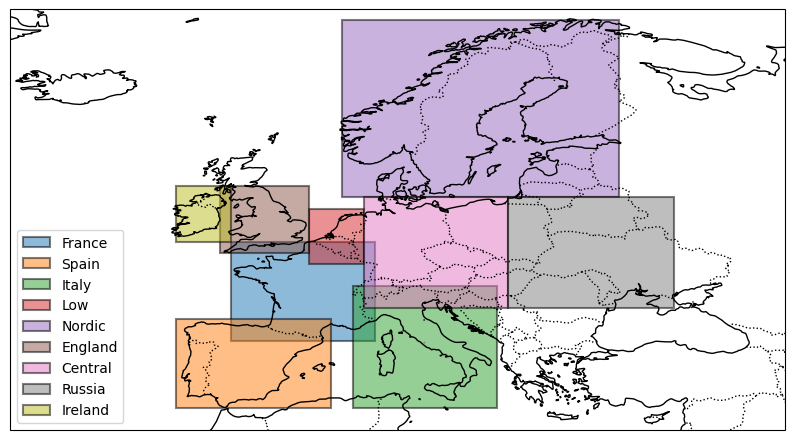

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

# Define colors for each region (or cycle through them)
colors = list(mcolors.TABLEAU_COLORS.values())

# Create figure and map
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# 🌍 Zoom in on Europe
ax.set_extent([-25, 45, 34, 72], crs=ccrs.PlateCarree())

# Add base features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Draw each region as a rectangle
for i, (name, bounds) in enumerate(regions.items()):
    lat_min, lat_max = bounds["lat"]
    lon_min, lon_max = bounds["lon"]

    width = lon_max - lon_min
    height = lat_max - lat_min

    rect = Rectangle(
        (lon_min, lat_min),
        width,
        height,
        facecolor=colors[i % len(colors)],
        edgecolor='black',
        linewidth=1.5,
        alpha=0.5,
        transform=ccrs.PlateCarree(),
        label=name
    )
    ax.add_patch(rect)

# Add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower left')

plt.savefig('figures/plots/regions_map.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [10]:
big_df = pd.merge(big_df, df_temp, on=['Year', 'Region'], how='left')

# Precip 

In [ ]:
# Load dataset
# Load dataset
ds_p = xr.open_dataset('..data/ModE-RA_ensmean_totprec_anom_wrt_1901-2000_1421-2008_mon.nc')



# Apply latitude weighting
ds_p['prec'] = np.sqrt(np.cos(np.deg2rad(ds_p['latitude'])) + 1e-6) * ds_p['totprec']*86400*30

ds_p = ds_p.drop_vars('totprec')  # Drop original variable


# Compute regional means
regional_prec = []
for name, bounds in regions.items():
    lat_min, lat_max = bounds["lat"]
    lon_min, lon_max = bounds["lon"]
    
    ds_region = ds_p.where(
        (ds_p.latitude >= lat_min) & (ds_p.latitude <= lat_max) &
        (ds_p.longitude >= lon_min) & (ds_p.longitude <= lon_max),
        drop=True
    )
    
    ds_mean = ds_region.mean(dim=["latitude", "longitude"])
    ds_mean = ds_mean.rename({var: f"{name}_{var}" for var in ds_mean.data_vars})
    regional_prec.append(ds_mean)

# Merge regional means
regional_prec_ds = xr.merge(regional_prec)

# --- Shift ND months to the following year for proper seasonal grouping ---

winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_ndfj(time_array):
    """Shift Nov and Dec to the next year, so they group with Jan and Feb of year T."""
    return [
        cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t
        for t in time_array
    ]

# Filter only winter months and apply shifting
regional_prec_ds_winter = regional_prec_ds.sel(time=regional_prec_ds.time.dt.month.isin(winter_months))
regional_prec_ds_winter = regional_prec_ds_winter.assign_coords(
    time=("time", shift_ndfj(regional_prec_ds_winter['time'].values))
)

# Compute seasonal means
region_prec_winter = regional_prec_ds_winter.groupby('time.year').mean(dim='time')
region_prec_summer = regional_prec_ds.sel(time=regional_prec_ds.time.dt.month.isin(summer_months)).groupby('time.year').mean(dim='time')

# --- Compute European Domain-Average Temperatures ---

lat_bounds = (70, 35)
lon_bounds = (-15, 35)

xds_europe = ds_p.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

def compute_seasonal_mean(xds, months):
    return (xds.sel(time=xds.time.dt.month.isin(months))
              .groupby('time.year').mean(dim='time')
              .mean(dim=['latitude', 'longitude']))

prec_winter_europe = compute_seasonal_mean(xds_europe, winter_months)
prec_summer_europe = compute_seasonal_mean(xds_europe, summer_months)

# Combine into DataFrame
europe_prec_df = pd.DataFrame({
    'Year': prec_winter_europe.year.values,
    'precip_winter_europe': prec_winter_europe['prec'].values,
    'precip_summer_europe': prec_summer_europe['prec'].values
})

# --- Convert regional seasonal data to long DataFrame ---

def stack_region_temp(region_ds, suffix):
    return xr.concat(
        [region_ds[var].expand_dims(Region=[var.replace("_prec", "")]) for var in region_ds.data_vars],
        dim="Region"
    ).to_dataframe(name=f"precip_{suffix}").reset_index()

df_prec_winter = stack_region_temp(region_prec_winter, "winter")
df_prec_summer = stack_region_temp(region_prec_summer, "summer")

# Merge regional winter and summer temps
df_precip = pd.merge(df_prec_winter, df_prec_summer, on=['year', 'Region'], how='outer')
df_precip = df_precip.rename(columns={'year': 'Year'})

# Merge with European domain averages
df_precip = pd.merge(df_precip, europe_prec_df, on='Year', how='outer')

#filter 1422-2000
df_precip = df_precip[df_precip['Year'] >= 1422]
df_precip = df_precip[df_precip['Year'] <= 2000]

C:\Users\emile\AppData\Local\Temp\ipykernel_20456\3284490093.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds_p = xr.open_dataset('data/ModE-RA_ensmean_totprec_anom_wrt_1901-2000_1421-2008_mon.nc')


In [12]:
big_df = pd.merge(big_df, df_precip, on=['Year', 'Region'], how='left')

# PDSI

In [ ]:
owda = xr.open_dataset("..data/owda.nc")

# Compute latitude-weighted PDSI
owda["PDSI"] = np.sqrt(np.cos(np.deg2rad(owda["lat"])) + 1e-6) * owda["pdsi"]
owda = owda.drop_vars("pdsi")  # Drop original variable


# Compute regional means
regional_pdsi = []
for name, bounds in regions.items():
    lat_min, lat_max = bounds["lat"]
    lon_min, lon_max = bounds["lon"]
    
    ds_region = owda.where(
        (owda.lat >= lat_min) & (owda.lat <= lat_max) &
        (owda.lon >= lon_min) & (owda.lon <= lon_max),
        drop=True
    )
    
    ds_mean = ds_region.mean(dim=["lat", "lon"])
    ds_mean = ds_mean.rename({var: f"{name}_{var}" for var in ds_mean.data_vars})
    regional_pdsi.append(ds_mean)

# Merge regional means
regional_pdsi_ds = xr.merge(regional_pdsi)

df_pdsi_region = xr.concat(
        [regional_pdsi_ds[var].expand_dims(Region=[var.replace("_PDSI", "")]) for var in regional_pdsi_ds.data_vars],
        dim="Region"
    ).to_dataframe(name=f"PDSI").reset_index()

df_pdsi_region = df_pdsi_region.rename(columns={'time': 'Year'})

df_pdsi = owda.mean(dim=['lat','lon']).to_dataframe().reset_index()
df_pdsi = df_pdsi.rename(columns={'time': 'Year', 'PDSI': 'PDSI_europe'})
df_pdsi['Year'] = df_pdsi['Year'].astype(int)

pdsi_df = pd.merge(df_pdsi, df_pdsi_region, on=['Year'], how='left')

In [14]:
big_df = pd.merge(big_df,pdsi_df,how='left',on=['Year','Region'])

# ENSO

In [ ]:


enso3 = pd.read_csv("..data/cook2024-R15-ENSO-Rec-1500-2000.txt", delimiter="\t", comment="#", na_values="NA")
lat_lon = pd.read_csv("..data/cook2024-ENSO-latlon.txt", delimiter="\t", comment="#", na_values="NA")

# Melt the ENSO DataFrame to long format
enso_melted = enso3.melt(id_vars=["Year"], var_name="gridpoint", value_name="enso")
enso_melted["gridpoint"] = enso_melted["gridpoint"].astype(int)

# Merge with the lat/lon DataFrame
enso_merged = enso_melted.merge(lat_lon, on="gridpoint")

# Convert to xarray
enso_xr = enso_merged.set_index(["Year", "lat", "lon"])["enso"].to_xarray()

enso_xr = enso_xr  - enso_xr.sel(Year=slice(1801, 1900)).mean(dim="Year")

#enso_xr = enso_xr- enso_xr.rolling(Year=50, min_periods=1).mean()



nino3 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-150, -90)).mean(dim=["lat", "lon"])
nino34 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-170, -120)).mean(dim=["lat", "lon"])
nino4 = enso_xr.sel(lat=slice(-5, 5), lon = slice(-200, -150)).mean(dim=["lat", "lon"])
nino12 = enso_xr.sel(lat=slice(-10, 0), lon=slice(-90, -80)).mean(dim=["lat", "lon"])


enso = pd.merge(nino34.to_dataframe().reset_index().rename(columns={"enso": "nino34"}), nino3.to_dataframe().reset_index().rename(columns={"enso": "nino3"}), on="Year")
enso = pd.merge(enso, nino4.to_dataframe().reset_index().rename(columns={"enso": "nino4"}), on="Year")
enso = pd.merge(enso, nino12.to_dataframe().reset_index().rename(columns={"enso": "nino12"}), on="Year")



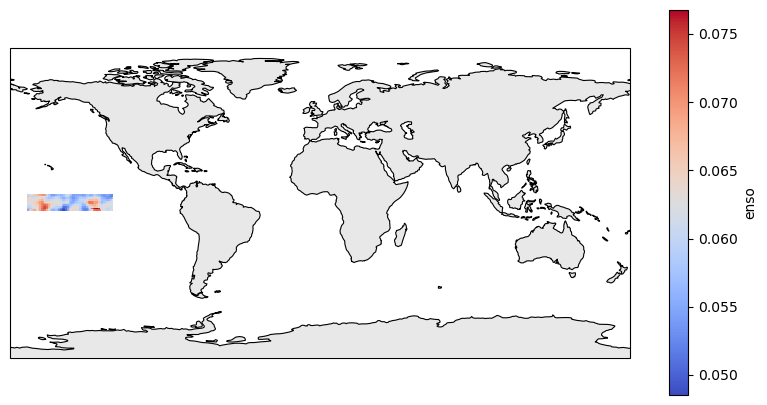

In [16]:
enso_subset = enso_xr.sel(lat=slice(-5, 5), lon=slice(-170, -120)).mean('Year')
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Create figure with a global projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Add global coastlines and land
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)

# Plot the selected region as part of the whole world
im = enso_subset.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', 
                      add_colorbar=True, vmin=enso_subset.min(), vmax=enso_subset.max())

# Set global extent
ax.set_global()

# Show the plot
plt.show()

In [ ]:

big_df = pd.merge(big_df, enso, on="Year", how="left")


# NAO

In [ ]:
nao_cal = pd.read_excel("..data/nao_reconst.xlsx", sheet_name="Figure 2a", header=3)
nao_cal = nao_cal.rename(columns={"Time (years AD)" : "Year"})
nao_model = pd.read_excel("..data/nao_reconst.xlsx", sheet_name="Figure 2b", header=3)
nao_model = nao_model.rename(columns={"Time (years AD)" : "Year"})

nao = pd.merge(nao_cal, nao_model, on="Year", suffixes=('_cal', '_model'))

nao = nao.rename(columns={"Ensemble Mean_cal" : "NAO_cal", "Ensemble Mean_model" : "NAO_model"})[["Year", "NAO_cal", "NAO_model"]]

big_df = pd.merge(big_df, nao, on="Year", how="left")

c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# Jet Stream

In [ ]:
jsl = pd.read_excel("..data/reconstructed EU JSL.xlsx")

big_df = pd.merge(big_df, jsl, on="Year", how="left")


In [22]:
data = big_df

In [23]:
data.describe()

,Year,Famine,Deaths,ongoing_wars,started_wars,total_duration,Death_ratio,temp_winter,temp_summer,temp_winter_europe,...,PDSI,nino34,nino3,nino4,nino12,ElNino,LaNina,NAO_cal,NAO_model,JSL
count,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,...,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000
mean,1650.000000,0.172019,68205.266888,6.916944,1.933555,6.953488,10535.779941,-0.166650,-0.180129,-0.124844,...,-0.144214,0.051419,0.050250,0.050608,0.049024,0.169435,0.139535,-0.095093,-0.140151,-0.504542
std,86.906778,0.377467,102296.026963,3.892495,1.621044,8.421462,14828.495029,0.710370,0.419943,0.355301,...,1.154623,0.663603,0.646098,0.610389,0.576199,0.375205,0.346568,0.491801,0.782420,2.028144
min,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.349265,-1.944442,-1.171608,...,-4.827694,-1.952120,-1.925507,-1.785379,-1.757992,0.000000,0.000000,-1.426310,-2.109830,-5.371419
25%,1575.000000,0.000000,6583.333333,4.000000,1.000000,1.000000,1122.222222,-0.554981,-0.433508,-0.368299,...,-0.812265,-0.403260,-0.385270,-0.365335,-0.337635,0.000000,0.000000,-0.440182,-0.675710,-1.808057
50%,1650.000000,0.000000,22588.235294,7.000000,2.000000,4.000000,2829.166667,-0.144307,-0.187177,-0.116869,...,-0.100226,0.012672,0.021873,0.012811,0.037335,0.000000,0.000000,-0.130771,-0.093332,-0.403734
75%,1725.000000,0.000000,80588.235294,9.000000,3.000000,10.000000,18348.333333,0.251605,0.070196,0.145536,...,0.550788,0.484910,0.470205,0.439501,0.428426,0.000000,0.000000,0.227544,0.370736,0.715459
max,1800.000000,1.000000,446412.373272,18.000000,7.000000,48.000000,95750.000000,2.651405,1.582236,0.733850,...,3.971290,2.167496,2.137185,1.968458,1.963324,1.000000,1.000000,1.232830,2.206950,6.611370


In [24]:
#count max number of locations per year
print(data['Year'].value_counts().max(), 'max number of locations per year')
#count max number ofunique years per location
print(data['Region'].value_counts().max(), 'max number of unique years per city')

9 max number of locations per year
301 max number of unique years per city


# Lag 

In [25]:
data['Century'] = (data['Year'] // 100) + 1

# Ensure 'location' is the name of your location identifier column
data['Famine_before'] = data.groupby('Region')['Famine'].shift(1).fillna(0).astype(int)
data['Famine_after'] = data.groupby('Region')['Famine'].shift(-1).fillna(0).astype(int)
data['Famine_after2'] = data.groupby('Region')['Famine'].shift(-2).fillna(0).astype(int)

# Identify the first year of a famine sequence lasting at least 2 years
data['Famine2Y'] = (
    (data['Famine'] == 1) & 
    (data['Famine_after'] == 1) & 
    (data['Famine_before'] == 0)
).astype(int)

# Identify the first year of a famine sequence lasting at least 3 years
data['Famine3Y'] = (
    (data['Famine'] == 1) & 
    (data['Famine_after'] == 1) & 
    (data['Famine_after2'] == 1) & 
    (data['Famine_before'] == 0)
).astype(int)

#create a variable for famines that are just one year no before no after

data['Famine1Y'] = (
    (data['Famine'] == 1) & 
    (data['Famine_after'] == 0) & 
    (data['Famine_before'] == 0)
).astype(int)

# Famine merge

In [26]:
data = pd.merge(data, famine_df, on=['Year', 'Region'], how='left')
data['Famine_dur'] = data['Famine_dur'].fillna(0)
data['Famine_dur2'] = data['Famine_dur2'].fillna(0)
data['Famine_start'] = np.where(data['Famine_dur'] > 0, 1, 0)

#rename Region England to Great Britain and Low to Low countries
data['Region'] = data['Region'].replace({'England': 'Great Britain', 'Low': 'Low Countries', 'Central': 'Central Europe', 'Russia': 'Russia/Ukraine',
                                            'Nordic': 'Nordic Countries'})

data['Famine_end'] = data['Famine_start'] + data['Famine_dur'].astype(int)

# save

In [ ]:
data.to_csv('..processed data/famine_region_data.csv', index=False)